# Import e setup

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [3]:
import random

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Definition of LeNet model with Dropout

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.dropout2d1 = nn.Dropout2d(p=0.2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.dropout2d2 = nn.Dropout2d(p=0.2)

        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.dropout1 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(120, 84)
        self.dropout2 = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout2d1(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout2d2(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

# Uploading MNIST and select of images "1"

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True)

for img, label in testloader:
    if label.item() == 1:
        base_img = img
        break


100%|██████████| 9.91M/9.91M [00:01<00:00, 5.11MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.28MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.46MB/s]


# Creation of rotated images

In [6]:
rotated_imgs = []
angles = list(range(0, 185, 5))
for angle in angles:
    pil_img = transforms.ToPILImage()(base_img.squeeze(0))
    rotated = pil_img.rotate(angle)
    rotated_tensor = transform(rotated).unsqueeze(0)
    rotated_imgs.append((angle, rotated_tensor))


# Simple training of the model

In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset_full = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

train_len = int(0.9 * len(trainset_full))
val_len = len(trainset_full) - train_len
trainset, valset = random_split(trainset_full, [train_len, val_len])

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
valloader = DataLoader(valset, batch_size=64, shuffle=False)

model = Net()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(trainloader)
    print(f"Epoch {epoch+1}/{num_epochs} - Training Loss: {avg_loss:.4f}")

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in valloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_acc = 100 * correct / total
    print(f"Validation Accuracy: {val_acc:.2f}%")

Epoch 1/15 - Training Loss: 0.5894
Validation Accuracy: 96.40%
Epoch 2/15 - Training Loss: 0.2271
Validation Accuracy: 97.70%
Epoch 3/15 - Training Loss: 0.1858
Validation Accuracy: 97.68%
Epoch 4/15 - Training Loss: 0.1605
Validation Accuracy: 98.12%
Epoch 5/15 - Training Loss: 0.1492
Validation Accuracy: 98.32%
Epoch 6/15 - Training Loss: 0.1395
Validation Accuracy: 98.47%
Epoch 7/15 - Training Loss: 0.1285
Validation Accuracy: 98.28%
Epoch 8/15 - Training Loss: 0.1259
Validation Accuracy: 98.55%
Epoch 9/15 - Training Loss: 0.1193
Validation Accuracy: 98.42%
Epoch 10/15 - Training Loss: 0.1156
Validation Accuracy: 98.57%
Epoch 11/15 - Training Loss: 0.1124
Validation Accuracy: 98.62%
Epoch 12/15 - Training Loss: 0.1073
Validation Accuracy: 98.60%
Epoch 13/15 - Training Loss: 0.1053
Validation Accuracy: 98.55%
Epoch 14/15 - Training Loss: 0.1008
Validation Accuracy: 98.58%
Epoch 15/15 - Training Loss: 0.1037
Validation Accuracy: 98.55%


# MC Dropout active to test-time

In [8]:
def predict_mc(model, image, T=100):
    model.train()
    softmax = nn.Softmax(dim=1)
    predictions = []

    with torch.no_grad():
        for _ in range(T):
            output = model(image.to(device))
            probs = softmax(output)
            predictions.append(probs.cpu().numpy())

    return np.array(predictions)

def compute_uncertainty(mc_probs):
    T, _, C = mc_probs.shape
    probs = mc_probs.squeeze(1)

    p_mean = np.mean(probs, axis=0)
    entropy_pred = -np.sum(p_mean * np.log(p_mean + 1e-8))

    entropy_per_sample = -np.sum(probs * np.log(probs + 1e-8), axis=1)
    expected_entropy = np.mean(entropy_per_sample)

    mutual_info = entropy_pred - expected_entropy

    return entropy_pred, expected_entropy, mutual_info

# Evaluation on rotated images

0°: Pred: 1, MI: 0.10
5°: Pred: 1, MI: 0.39
10°: Pred: 1, MI: 0.04
15°: Pred: 1, MI: 0.07
20°: Pred: 1, MI: 0.24
25°: Pred: 1, MI: 0.13
30°: Pred: 1, MI: 0.21
35°: Pred: 1, MI: 0.30
40°: Pred: 1, MI: 0.29
45°: Pred: 1, MI: 0.48
50°: Pred: 1, MI: 0.39
55°: Pred: 1, MI: 0.69
60°: Pred: 1, MI: 0.63
65°: Pred: 8, MI: 0.52
70°: Pred: 2, MI: 0.50
75°: Pred: 2, MI: 0.56
80°: Pred: 2, MI: 0.52
85°: Pred: 4, MI: 0.52
90°: Pred: 2, MI: 0.75
95°: Pred: 2, MI: 0.62
100°: Pred: 4, MI: 0.65
105°: Pred: 7, MI: 0.68
110°: Pred: 7, MI: 0.73
115°: Pred: 7, MI: 0.75
120°: Pred: 7, MI: 0.69
125°: Pred: 5, MI: 0.80
130°: Pred: 5, MI: 0.61
135°: Pred: 5, MI: 0.37
140°: Pred: 5, MI: 0.49
145°: Pred: 5, MI: 0.42
150°: Pred: 1, MI: 0.63
155°: Pred: 1, MI: 0.40
160°: Pred: 1, MI: 0.42
165°: Pred: 1, MI: 0.27
170°: Pred: 1, MI: 0.25
175°: Pred: 1, MI: 0.03
180°: Pred: 1, MI: 0.05


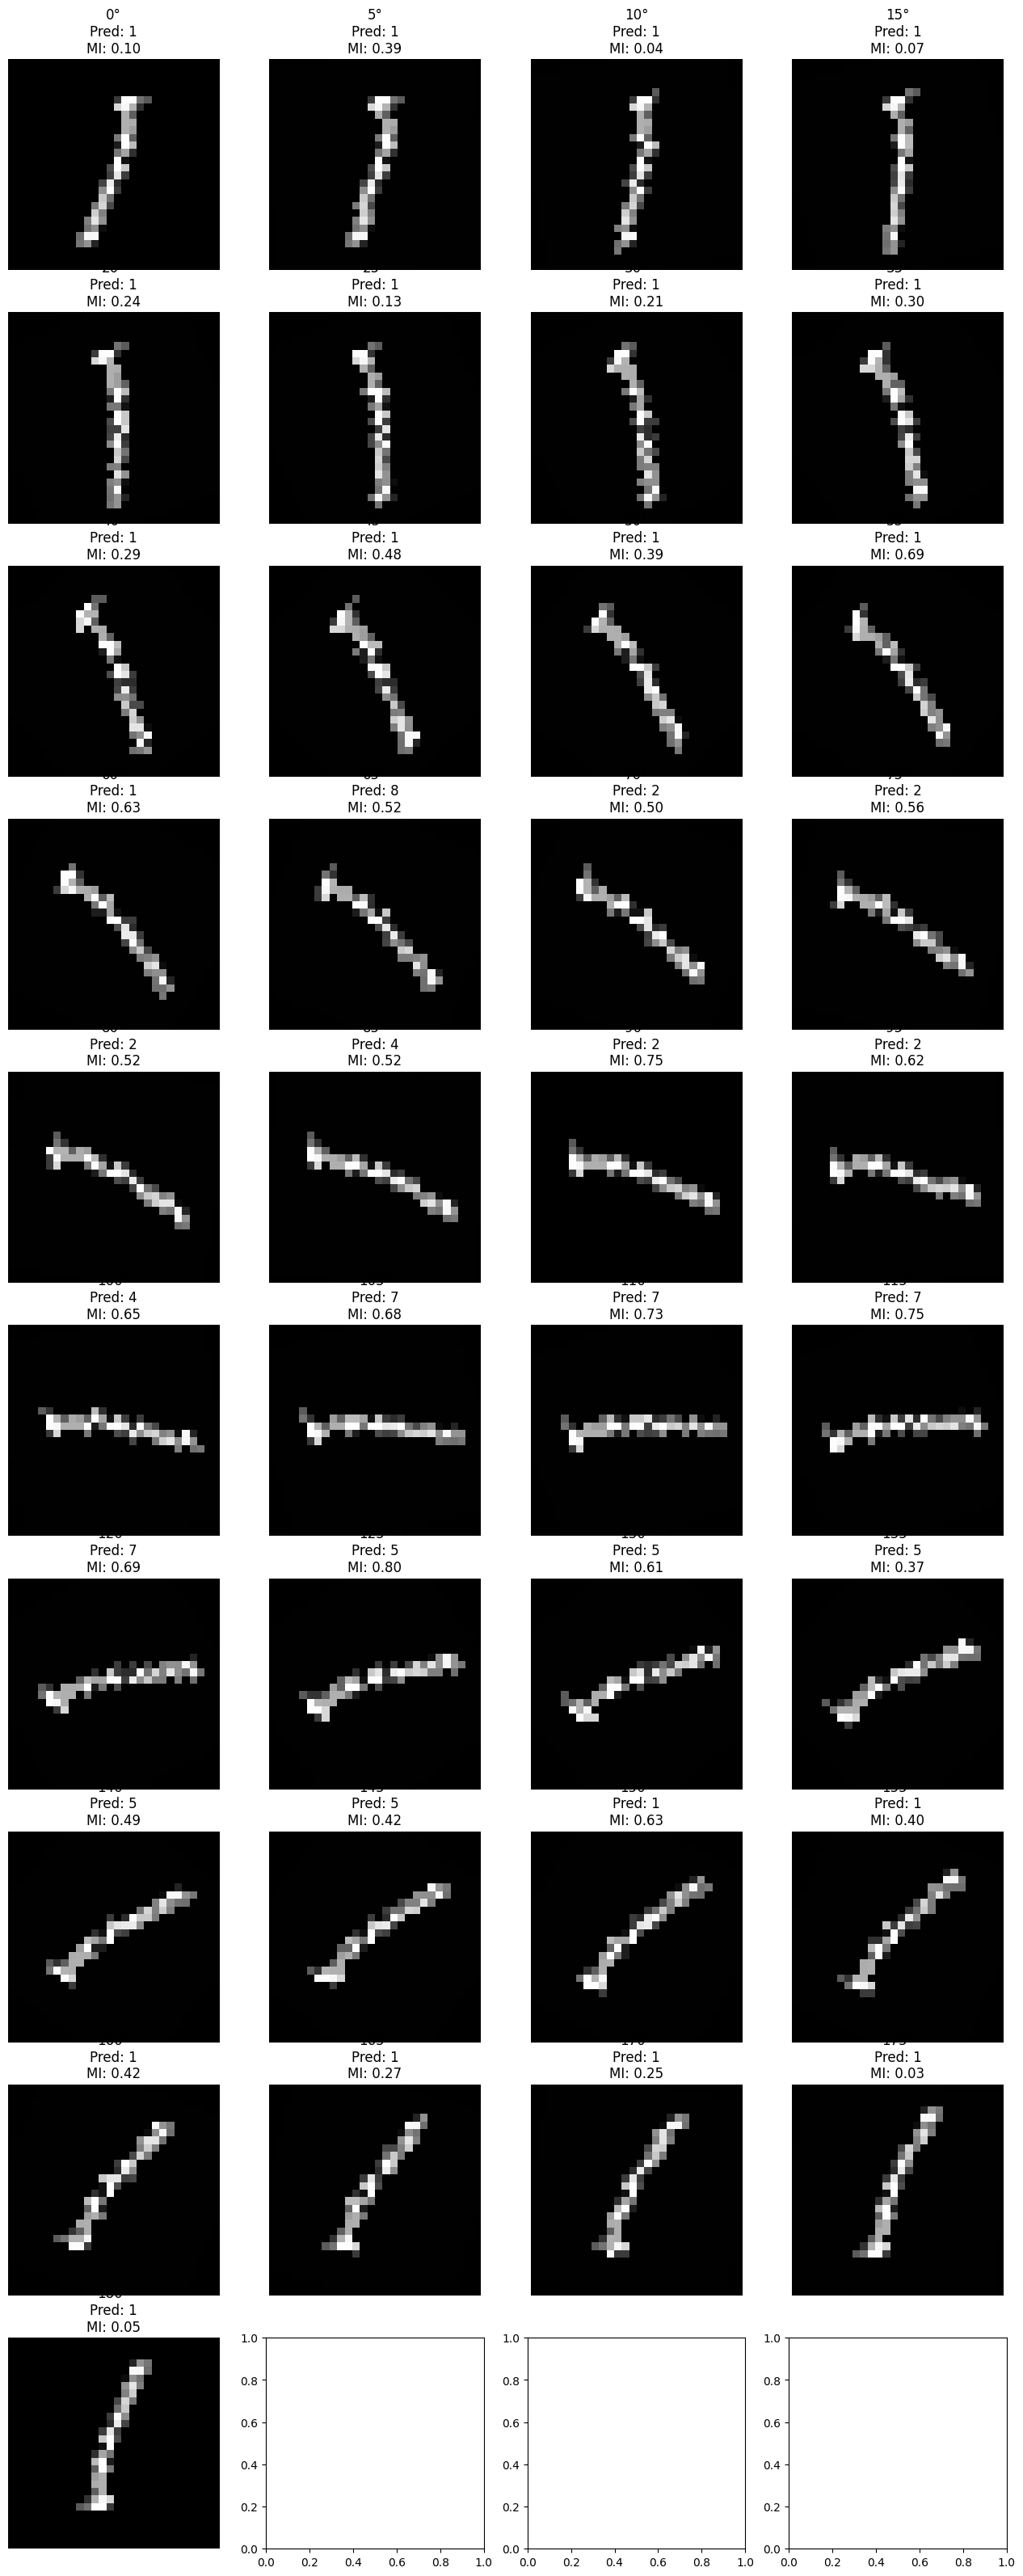

In [9]:
import matplotlib.pyplot as plt
import math

num_images = len(rotated_imgs)
cols = 4
rows = math.ceil(num_images / cols)
fig, axs = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
axs = axs.flatten()

for i, (angle, img) in enumerate(rotated_imgs):
    preds = predict_mc(model, img, T=100)
    mean_pred = preds.mean(axis=0).squeeze()
    pred_label = np.argmax(mean_pred)

    entropy, expected_entropy, mi = compute_uncertainty(preds)

    ax = axs[i]
    ax.imshow(img.squeeze(0).squeeze(0), cmap='gray')
    ax.set_title(f"{angle}°\nPred: {pred_label}\nMI: {mi:.2f}")
    ax.axis('off')
    print(f"{angle}°: Pred: {pred_label}, MI: {mi:.2f}")

# Breaking Point

Breaking point (label changes from 1): 65°


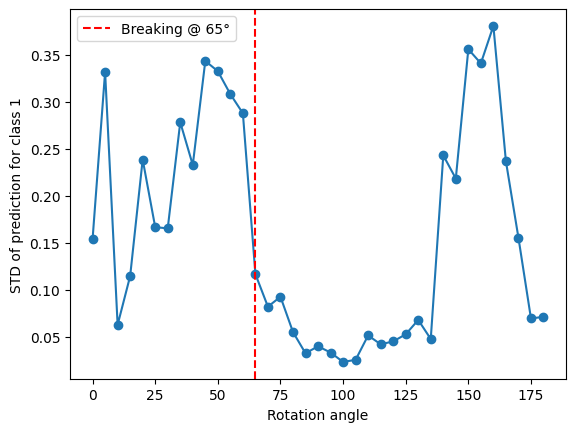

In [10]:
original_label = 1
fine_angles = list(range(0, 185, 5))

breaking_point = None
stds = []

for angle in fine_angles:
    pil_img = transforms.ToPILImage()(base_img.squeeze(0))
    rotated = pil_img.rotate(angle)
    img_tensor = transform(rotated).unsqueeze(0)
    preds = predict_mc(model, img_tensor, T=100)
    mean_pred = preds.mean(axis=0).squeeze()
    std_pred = preds.std(axis=0).squeeze()
    pred_label = int(np.argmax(mean_pred))
    stds.append(std_pred[original_label])

    if breaking_point is None and pred_label != original_label:
        breaking_point = angle

print(f"Breaking point (label changes from 1): {breaking_point}°")

import matplotlib.pyplot as plt
plt.plot(fine_angles, stds, marker='o')
plt.axvline(breaking_point, color='red', linestyle='--', label=f'Breaking @ {breaking_point}°')
plt.xlabel('Rotation angle')
plt.ylabel(f'STD of prediction for class {original_label}')
plt.legend()
plt.show()


# Comparison between different digits

,1,4,7,9
0,0.071466,0.181587,0.044366,0.081857
5,0.026574,0.262640,0.092867,0.049377
10,0.052249,0.152559,0.049652,0.165326
15,0.153216,0.242817,0.167974,0.130259
20,0.165015,0.277292,0.209172,0.092105
25,0.187190,0.301834,0.351806,0.121952
30,0.255138,0.290889,0.307376,0.131662
35,0.339907,0.155196,0.323412,0.113869
40,0.339333,0.115431,0.319446,0.097986
45,0.201212,0.083135,0.192151,0.182534


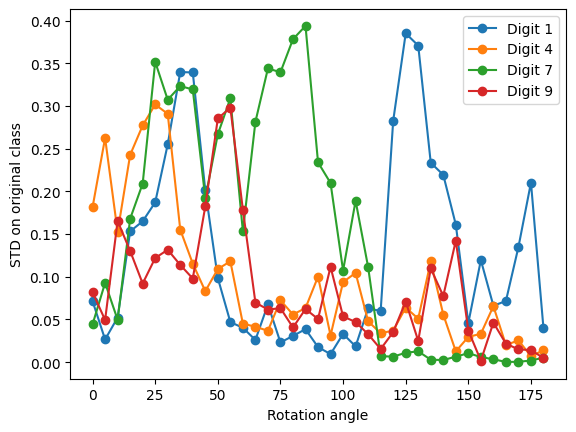

In [11]:
digits = [1, 4, 7, 9]
angles = list(range(0, 185, 5))
results = {d: [] for d in digits}

for d in digits:
    for img, label in testloader:
        if label.item() == d:
            base = img
            break
    for angle in angles:
        pil_img = transforms.ToPILImage()(base.squeeze(0))
        rotated = pil_img.rotate(angle)
        img_tensor = transform(rotated).unsqueeze(0)
        preds = predict_mc(model, img_tensor, T=100)
        mean_pred = preds.mean(axis=0).squeeze()
        std_pred = preds.std(axis=0).squeeze()
        orig_std = std_pred[d]
        results[d].append(orig_std)

import pandas as pd
from IPython.display import display
df = pd.DataFrame(results, index=angles)
display(df)

for d in digits:
    plt.plot(angles, results[d], marker='o', label=f'Digit {d}')
plt.xlabel('Rotation angle')
plt.ylabel('STD on original class')
plt.legend()
plt.show()


# Data Augmentation vs normal training

Training base model (no augmentation)…


Epoch 15/15: 100%|██████████| 938/938 [00:17<00:00, 53.47it/s, loss=0.101]



Training augmented model…


Epoch 15/15: 100%|██████████| 938/938 [00:23<00:00, 39.54it/s, loss=0.142]


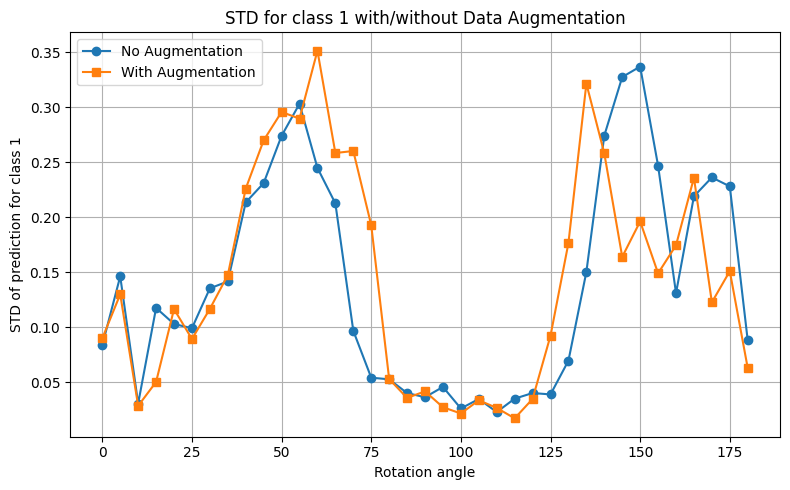

In [12]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

seed = 42
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

batch_size = 64
lr = 1e-3
epochs = 15
T_mc = 100

def train_model(model, dataloader, optimizer, criterion, device, epochs):
    model.train()
    for epoch in range(epochs):
        loop = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")
        total_loss = 0.0
        for imgs, labels in loop:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * imgs.size(0)
            loop.set_postfix(loss=total_loss / ((loop.n+1)*batch_size))
    return model

trainset = torchvision.datasets.MNIST(
    root="./data", train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
)
loader_base = DataLoader(trainset, batch_size=batch_size, shuffle=True)

trainset_aug = torchvision.datasets.MNIST(
    root="./data", train=True, download=True,
    transform=transforms.Compose([
        transforms.RandomRotation(20),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
)
loader_aug = DataLoader(trainset_aug, batch_size=batch_size, shuffle=True)

model_base = Net().to(device)
model_aug  = Net().to(device)

opt_base = torch.optim.Adam(model_base.parameters(), lr=lr)
opt_aug  = torch.optim.Adam(model_aug.parameters(), lr=lr)

criterion = nn.CrossEntropyLoss()

print("Training base model (no augmentation)…")
model_base = train_model(model_base, loader_base, opt_base, criterion, device, epochs)

print("\nTraining augmented model…")
model_aug  = train_model(model_aug, loader_aug, opt_aug, criterion, device, epochs)

def mc_std(model, image, T=T_mc):
    model.train()
    preds = []
    with torch.no_grad():
        for _ in range(T):
            out = model(image.to(device))
            probs = F.softmax(out, dim=1).cpu().numpy()
            preds.append(probs)
    preds = np.array(preds)
    return preds.std(axis=0).squeeze()

stds_base = []
stds_augm = []
for angle, img in rotated_imgs:
    stds_base.append(mc_std(model_base, img)[1])
    stds_augm.append(mc_std(model_aug, img)[1])

plt.figure(figsize=(8,5))
plt.plot(angles, stds_base, marker='o', label='No Augmentation')
plt.plot(angles, stds_augm, marker='s', label='With Augmentation')
plt.title("STD for class 1 with/without Data Augmentation")
plt.xlabel("Rotation angle")
plt.ylabel("STD of prediction for class 1")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [13]:
digits_to_test = [1, 4, 7, 9]
angles = list(range(0, 185, 5))
results_all_digits = []

for digit in digits_to_test:
    for img, label in testloader:
        if label.item() == digit:
            base_digit_img = img
            break

    rotated_digit_imgs = []
    for angle in angles:
        pil_img = transforms.ToPILImage()(base_digit_img.squeeze(0))
        rotated = pil_img.rotate(angle)
        img_tensor = transform(rotated).unsqueeze(0)
        rotated_digit_imgs.append((angle, img_tensor))

    for model_name, model_obj in [("No Augmentation", model_base), ("With Augmentation", model_aug)]:
        for angle, img in rotated_digit_imgs:
            model_obj.train()
            preds = []
            with torch.no_grad():
                for _ in range(100):
                    out = model_obj(img.to(device))
                    probs = F.softmax(out, dim=1).cpu().numpy()
                    preds.append(probs)
            preds = np.array(preds)
            mean_pred = preds.mean(axis=0).squeeze()
            std_pred = preds.std(axis=0).squeeze()
            pred_label = int(np.argmax(mean_pred))
            std_of_pred = float(std_pred[pred_label])
            correct = (pred_label == digit)
            results_all_digits.append({
                "Digit": digit,
                "Model": model_name,
                "Angle": angle,
                "Predicted Label": pred_label,
                "STD of Pred": std_of_pred,
                "Correct": correct
            })

df_all_digits = pd.DataFrame(results_all_digits)


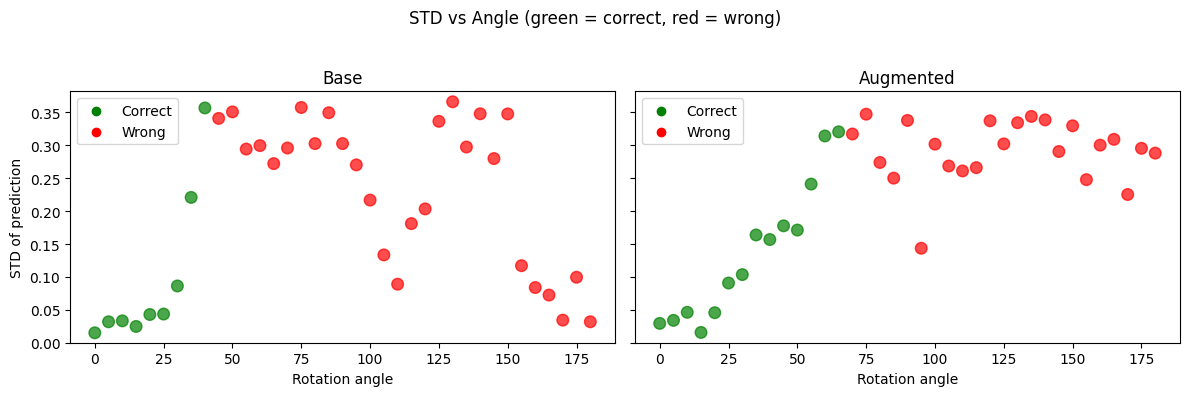

In [14]:
import matplotlib.pyplot as plt

df_plot = df_all_digits[df_all_digits["Digit"] == 9].copy()
df_plot['Model'] = df_plot['Model'].map({
    'No Augmentation': 'Base',
    'With Augmentation': 'Augmented'
})

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
for ax, model_name in zip(axes, ['Base', 'Augmented']):
    sub = df_plot[df_plot['Model'] == model_name]
    colors = sub['Correct'].map({True: 'green', False: 'red'})
    ax.scatter(sub['Angle'], sub['STD of Pred'], c=colors, s=70, alpha=0.7)
    ax.set_title(f"{model_name}")
    ax.set_xlabel("Rotation angle")
    ax.set_ylim(0, sub['STD of Pred'].max() * 1.1)
    if ax is axes[0]:
        ax.set_ylabel("STD of prediction")
    for c, label in zip(['green', 'red'], ['Correct', 'Wrong']):
        ax.scatter([], [], c=c, label=label)
    ax.legend()

plt.suptitle("STD vs Angle (green = correct, red = wrong)")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [15]:
import numpy as np

std_base = np.array([row['STD of Pred'] for i, row in df_plot[df_plot['Model'] == 'Base'].iterrows()])
std_aug  = np.array([row['STD of Pred'] for i, row in df_plot[df_plot['Model'] == 'Augmented'].iterrows()])
angles   = np.array([row['Angle'] for i, row in df_plot[df_plot['Model'] == 'Base'].iterrows()])

use_aug = std_aug < std_base

print("Use the AUGMENTED model for these angles:")
print(angles[use_aug])

print("\nUse the BASE model for these angles:")
print(angles[~use_aug])

from itertools import groupby
from operator import itemgetter

def find_intervals(angles_list):
    intervals = []
    for k, g in groupby(enumerate(angles_list), lambda x: x[0] - x[1]):
        group = list(map(itemgetter(1), g))
        intervals.append((group[0], group[-1]))
    return intervals

print("\nAUGMENTED intervals:", find_intervals(angles[use_aug]))
print("BASE intervals:", find_intervals(angles[~use_aug]))

Use the AUGMENTED model for these angles:
[ 15  35  40  45  50  55  75  80  85  95 125 130 140 150]

Use the BASE model for these angles:
[  0   5  10  20  25  30  60  65  70  90 100 105 110 115 120 135 145 155
 160 165 170 175 180]

AUGMENTED intervals: [(np.int64(15), np.int64(15)), (np.int64(35), np.int64(35)), (np.int64(40), np.int64(40)), (np.int64(45), np.int64(45)), (np.int64(50), np.int64(50)), (np.int64(55), np.int64(55)), (np.int64(75), np.int64(75)), (np.int64(80), np.int64(80)), (np.int64(85), np.int64(85)), (np.int64(95), np.int64(95)), (np.int64(125), np.int64(125)), (np.int64(130), np.int64(130)), (np.int64(140), np.int64(140)), (np.int64(150), np.int64(150))]
BASE intervals: [(np.int64(0), np.int64(0)), (np.int64(5), np.int64(5)), (np.int64(10), np.int64(10)), (np.int64(20), np.int64(20)), (np.int64(25), np.int64(25)), (np.int64(30), np.int64(30)), (np.int64(60), np.int64(60)), (np.int64(65), np.int64(65)), (np.int64(70), np.int64(70)), (np.int64(90), np.int64(90)), (np

# Toy Regression: Dropout as Bayesian Approximation

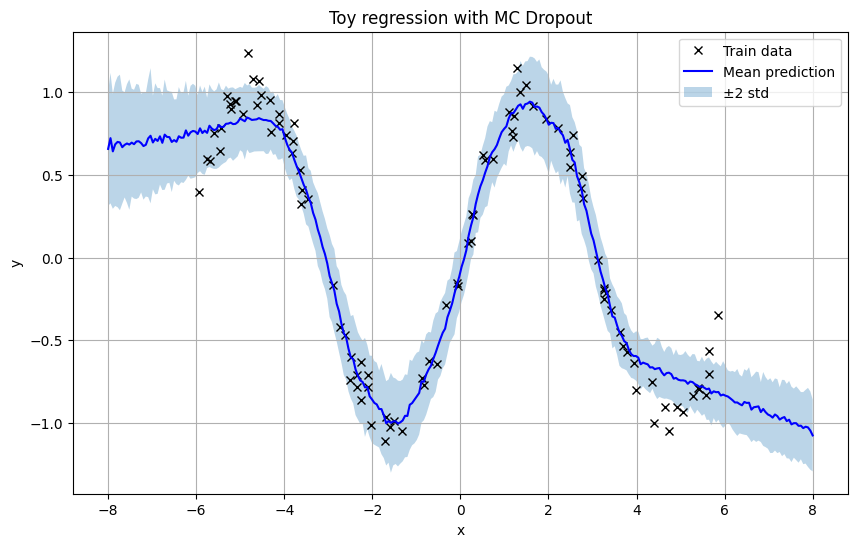

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

def generate_data(n_train=100):
    X = np.random.uniform(-6, 6, size=(n_train, 1))
    y = np.sin(X) + np.random.normal(0, 0.1, size=(n_train, 1))
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

class DropoutRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 100),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(100, 1)
        )

    def forward(self, x):
        return self.net(x)


def predict_mc_regression(model, x, T=100):
    model.train()
    preds = []
    with torch.no_grad():
        for _ in range(T):
            preds.append(model(x).cpu().numpy())
    preds = np.stack(preds)  # shape (T, N, 1)
    mean = preds.mean(axis=0).squeeze()
    std = preds.std(axis=0).squeeze()
    return mean, std


X_train, y_train = generate_data()
model_reg = DropoutRegressor()
optimizer = optim.Adam(model_reg.parameters(), lr=1e-3)
criterion = nn.MSELoss()

for epoch in range(1000):
    model_reg.train()
    optimizer.zero_grad()
    output = model_reg(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()


X_test = torch.linspace(-8, 8, 300).view(-1, 1)
mean, std = predict_mc_regression(model_reg, X_test, T=100)


plt.figure(figsize=(10, 6))
plt.plot(X_train.numpy(), y_train.numpy(), 'kx', label='Train data')
plt.plot(X_test.numpy(), mean, 'b', label='Mean prediction')
plt.fill_between(X_test.squeeze().numpy(), mean - 2*std, mean + 2*std, alpha=0.3, label='±2 std')
plt.legend()
plt.title("Toy regression with MC Dropout")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.show()

# Out-of-Distribution detection con Fashion-MNIST

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.8MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 176kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.26MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 9.89MB/s]


AUC OoD via Mutual Information: 0.967


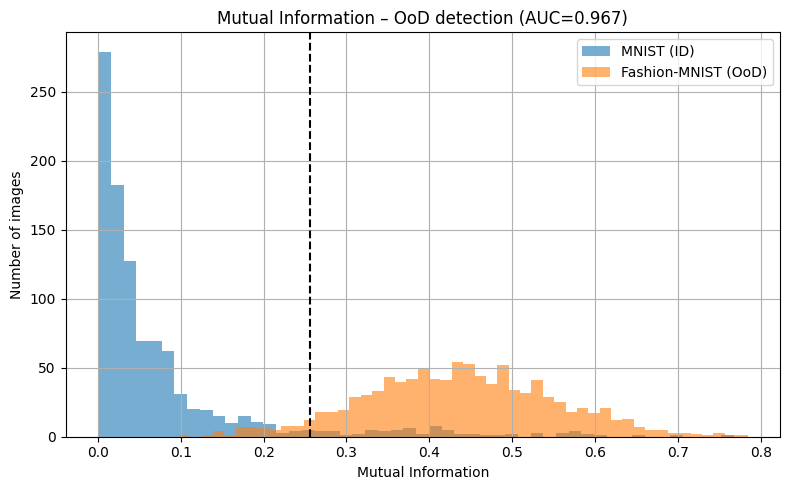

In [17]:
oodset = torchvision.datasets.FashionMNIST(
    root="./data", train=False, download=True, transform=transform)
oodloader = torch.utils.data.DataLoader(oodset, batch_size=1, shuffle=False)

def collect_mi(data_loader, n_samples=1000):
    mi_vals = []
    for i, (img, _) in enumerate(data_loader):
        if i >= n_samples:
            break
        preds = predict_mc(model, img, T=100)
        _, _, mi = compute_uncertainty(preds)
        mi_vals.append(mi)
    return np.array(mi_vals)

mi_in  = collect_mi(testloader)
mi_ood = collect_mi(oodloader)

from sklearn.metrics import roc_auc_score
labels  = np.concatenate([np.zeros_like(mi_in), np.ones_like(mi_ood)])
scores  = np.concatenate([mi_in, mi_ood])
auc_ood = roc_auc_score(labels, scores)
print(f"AUC OoD via Mutual Information: {auc_ood:.3f}")

plt.figure(figsize=(8,5))
plt.hist(mi_in,  bins=50, alpha=0.6, label="MNIST (ID)")
plt.hist(mi_ood, bins=50, alpha=0.6, label="Fashion-MNIST (OoD)")
plt.axvline(scores.mean(), color='k', linestyle='--')
plt.title(f"Mutual Information – OoD detection (AUC={auc_ood:.3f})")
plt.xlabel("Mutual Information")
plt.ylabel("Number of images")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()